In [1]:
import reading
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Flatten, InputLayer, Activation, Dropout
from tensorflow.keras.layers import Conv2D, Conv3D, AveragePooling2D, AveragePooling3D, MaxPooling2D, MaxPooling3D,GlobalAvgPool2D
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import roc_curve, auc
import os
from tensorflow.keras import layers

Import dataset

In [2]:
paths_FA= reading.data_path("Diffusion_parameters_maps-20230215T134959Z-001","corrected_FA_image")

paths_FA.sort(key=lambda x: int(os.path.basename(x).split('_')[3]))

dataset=pd.DataFrame(pd.read_csv('ADNI_dataset_diffusion.csv'))
dataset.sort_values(by=["Subject"],inplace=True)
dataset["Path"]=paths_FA
pd.set_option("max_colwidth",None)

dataset.head()

,Subject,Group,Sex,Age,Path
67,4002,0,F,74.0,Diffusion_parameters_maps-20230215T134959Z-001\Diffusion_parameters_maps\098_S_4002\corrected_FA_image\2011-02-28_15_42_50.0\I397180\ADNI_098_S_4002_MR_corrected_FA_image_Br_20131105134057196_S100616_I397180.nii
68,4003,0,F,72.0,Diffusion_parameters_maps-20230215T134959Z-001\Diffusion_parameters_maps\098_S_4003\corrected_FA_image\2011-03-22_09_23_47.0\I299742\ADNI_098_S_4003_MR_corrected_FA_image_Br_20120421215950180_S102157_I299742.nii
28,4009,1,M,90.0,Diffusion_parameters_maps-20230215T134959Z-001\Diffusion_parameters_maps\016_S_4009\corrected_FA_image\2011-06-18_12_22_12.0\I299644\ADNI_016_S_4009_MR_corrected_FA_image_Br_20120421205831338_S112088_I299644.nii
69,4018,0,M,76.0,Diffusion_parameters_maps-20230215T134959Z-001\Diffusion_parameters_maps\098_S_4018\corrected_FA_image\2011-04-22_15_36_10.0\I299744\ADNI_098_S_4018_MR_corrected_FA_image_Br_20120421220032350_S105027_I299744.nii
70,4050,0,M,77.0,Diffusion_parameters_maps-20230215T134959Z-001\Diffusion_parameters_maps\098_S_4050\corrected_FA_image\2011-05-27_15_33_58.0\I299745\ADNI_098_S_4050_MR_corrected_FA_image_Br_20120421220057813_S110467_I299745.nii


In [3]:
images_list = []
for i, datapath in enumerate(dataset["Path"]):
    image = np.asarray(nib.load(datapath).get_fdata())
    #image[image == 0] = float('NaN')
    images_list.append(image)
    
images = np.array(images_list, dtype='float64')
labels = np.array(dataset["Group"], dtype='int64')

Data augmentation

In [4]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

data_augmentation1 = Sequential([layers.RandomFlip(mode='horizontal_and_vertical')])

data_augmentation2 = Sequential([layers.RandomRotation((-0.5,0.5))])

data_augmentation3 = Sequential([layers.RandomZoom(0.5)])

In [5]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

imagesau2=data_augmentation2(images)

In [6]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

imagesau3=data_augmentation3(images)

In [7]:
images1=np.append(images,imagesau2,axis=0)
#images2=np.append(images1,imagesau2,axis=0)

In [8]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

images=np.append(images1,imagesau3,axis=0)

print(np.shape(images))

(291, 110, 110, 110)


In [9]:
labels1=np.append(labels,labels)
#labels2=np.append(labels1,labels)

labels=np.append(labels1,labels)

print(np.shape(labels))

(291,)


In [10]:
def split_2D():
    X_train, x_test, Y_train, y_test = train_test_split(images[:,:,:,53:56], labels, test_size=0.2, random_state=10)
    x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=20)
    return x_train, y_train, x_val, y_val, x_test, y_test

In [11]:
x_train, y_train, x_val, y_val, x_test, y_test = split_2D()
print(x_train.shape)

(174, 110, 110, 3)


In [12]:
def make_2D_CNN_best1(shape=(110, 110, 3)):
  model = Sequential([
      
      Conv2D(2, (5,5), padding='valid', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((2,2), strides=2),
      #Dropout(0.4),
      
      Conv2D(4, (5,5), padding='valid', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((3,3), strides=2),
      #Dropout(0.4),False
      
      Conv2D(8, (5,5), padding='valid', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((4,4), strides=2),
      #Dropout(0.4),
      
      Conv2D(16, (5,5), padding='valid', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((5,5), strides=2),
      #Dropout(0.4),False

      Flatten(),

      Dense(20, activation='relu'),
      #Dropout(0.1),
      Dense(1, activation='sigmoid')
     
  ])
  return model

In [37]:
def make_2D_CNN_best2(shape=(110, 110, 3)):
  model = Sequential([
      
      Conv2D(2, (5,5), padding='valid', input_shape=shape,kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((2,2), strides=2),
      #Dropout(0.4),
      
      Conv2D(4, (5,5), padding='valid', input_shape=shape,kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((3,3), strides=2),
      #Dropout(0.4),
      
      Conv2D(8, (5,5), padding='valid', input_shape=shape,kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((4,4), strides=2),
      #Dropout(0.4),
      
      Conv2D(16, (5,5), padding='valid', input_shape=shape,kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((5,5), strides=2),
      #Dropout(0.4),

      Flatten(),

      Dense(30, activation='relu'),
      #Dropout(0.1),
      Dense(1, activation='sigmoid')
     
  ])
  return model

In [14]:
def make_2D_CNN_best3(shape=(110, 110, 3)):
  model = Sequential([
      
      Conv2D(4, (5,5), padding='valid', input_shape=shape,kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((2,2), strides=2),
      #Dropout(0.4),
      
      Conv2D(8, (5,5), padding='valid', input_shape=shape,kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((3,3), strides=3),
      #Dropout(0.4),
      
      Conv2D(16, (5,5), padding='valid', input_shape=shape,kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((4,4), strides=2),
      #Dropout(0.4),

      Flatten(),

      Dense(20, activation='relu'),
      #Dropout(0.1),
      Dense(1, activation='sigmoid')
     
  ])
  return model

In [178]:
def make_2D_CNN(shape=(110, 110, 3)):
  model = Sequential([
      
      Conv2D(4, (3,3), padding='valid', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((2,2), strides=2),
      #Dropout(0.4),
      
      Conv2D(8, (3,3), padding='valid', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((3,3), strides=3),
      #Dropout(0.4),
      
      Conv2D(16, (3,3), padding='valid', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((4,4), strides=4),
      #Dropout(0.4),

      Flatten(),

      Dense(32, activation='relu'),
      #Dropout(0.1),
      Dense(1, activation='sigmoid')
     
  ])
  return model

In [179]:
model = make_2D_CNN()
model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_88 (Conv2D)          (None, 108, 108, 4)       112       
                                                                 
 batch_normalization_88 (Bat  (None, 108, 108, 4)      16        
 chNormalization)                                                
                                                                 
 activation_88 (Activation)  (None, 108, 108, 4)       0         
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 54, 54, 4)        0         
 g2D)                                                            
                                                                 
 conv2d_89 (Conv2D)          (None, 52, 52, 8)         296       
                                                                 
 batch_normalization_89 (Bat  (None, 52, 52, 8)      

In [180]:
model.compile(optimizer=SGD(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [181]:
reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=20,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=100,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=10)

In [ ]:
epochs= 1000
batch_size = 30
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch = round(len(x_train)/batch_size),
                    verbose=1,
                    validation_data=(x_val, y_val),
                    validation_steps=round(len(x_val)/batch_size),
                    callbacks=[reduce_on_plateau, early_stopping])

Epoch 1/1000
6/6 [==============================] - 2s 142ms/step - loss: 0.9337 - accuracy: 0.5690 - val_loss: 0.7033 - val_accuracy: 0.4310 - lr: 1.0000e-04
Epoch 2/1000
6/6 [==============================] - 1s 107ms/step - loss: 0.9186 - accuracy: 0.5747 - val_loss: 0.7064 - val_accuracy: 0.4310 - lr: 1.0000e-04
Epoch 3/1000
6/6 [==============================] - 1s 142ms/step - loss: 0.8995 - accuracy: 0.5747 - val_loss: 0.7082 - val_accuracy: 0.4310 - lr: 1.0000e-04
Epoch 4/1000
6/6 [==============================] - 1s 107ms/step - loss: 0.8879 - accuracy: 0.5747 - val_loss: 0.7106 - val_accuracy: 0.4310 - lr: 1.0000e-04
Epoch 5/1000
6/6 [==============================] - 1s 107ms/step - loss: 0.8724 - accuracy: 0.5747 - val_loss: 0.7137 - val_accuracy: 0.4310 - lr: 1.0000e-04
Epoch 6/1000
6/6 [==============================] - 1s 107ms/step - loss: 0.8620 - accuracy: 0.5690 - val_loss: 0.7175 - val_accuracy: 0.4310 - lr: 1.0000e-04
Epoch 7/1000
6/6 [============================

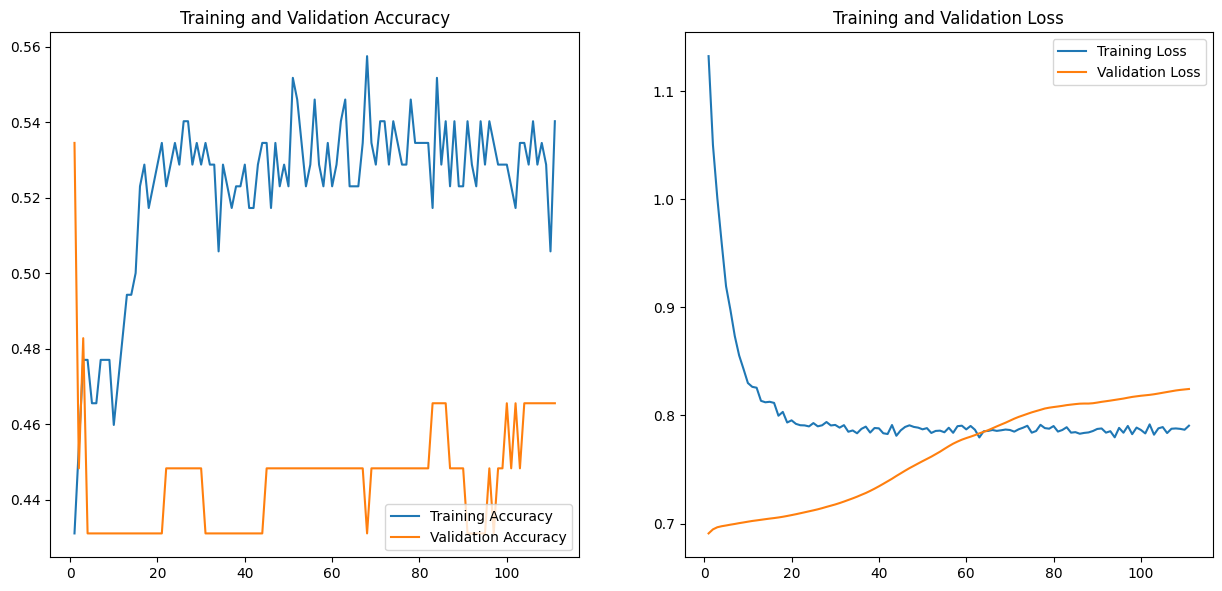

In [177]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc)+1)
#Train and validation accuracy 
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#Train and validation loss 
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Validation accuracy: 0.586
2/2 [==============================] - 0s 46ms/step
AUC = 0.556


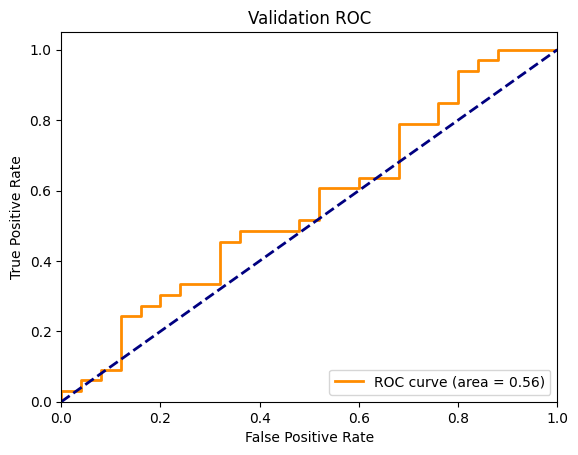

In [92]:
_, val_acc = model.evaluate(x_val, y_val, verbose=0)
print('Validation accuracy: %.3f' % (val_acc))

preds = model.predict(x_val, verbose=1)
#Compute Receiver operating characteristic (ROC)
fpr, tpr, _ = roc_curve(y_val, preds)
roc_auc = auc(fpr, tpr)
print('AUC = %.3f'% (roc_auc))

#Plot of a ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC')
plt.legend(loc="lower right")
plt.show()

2/2 [==============================] - 0s 32ms/step - loss: 0.7281 - accuracy: 0.4915

Test accuracy: 0.492
2/2 [==============================] - 0s 18ms/step
AUC = 0.502


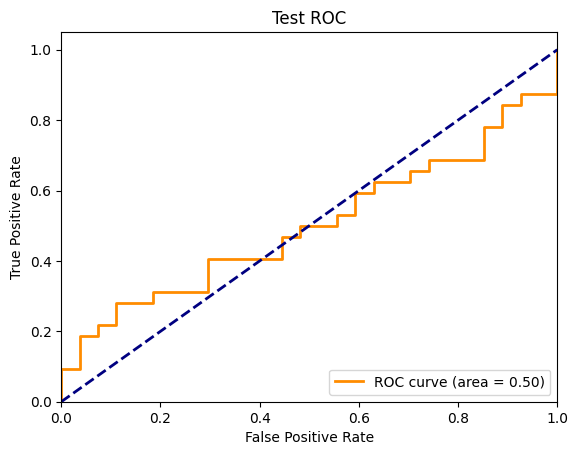

In [93]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy: %.3f' % (test_acc))

preds_test = model.predict(x_test, verbose=1)
fpr, tpr, _ = roc_curve(y_test, preds_test)
roc_auc = auc(fpr, tpr)
print('AUC = %.3f'% (roc_auc))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC')
plt.legend(loc="lower right")
plt.show()